# Triton Fused Softmax

We are going to implement a fused softmax using Triton, as we want to rely on Python syntax to write an efficient kernel. When dealing with operations that we want to parallelize, we first need to gain insight from the actual equation to determine which parts can be done in parallel and identify important properties that can facilitate computation.

To wrap up:

- Triton as a more accessible GPU programming language.
- Analyzing the equation we want to parallelize.

Softmax Equation:

  - Eager Mode


In [2]:
# In eager mode (the default in PyTorch), every line executes immediately , and the computation graph is constructed dynamically as we run the code.
import torch
def softmax_eq(x: torch.Tensor) -> torch.Tensor: 
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True) # NOTE: In PyTorch, dim=1 means we are aggregating across the columns ~= In Triton, program_id(1) is used to access or index the column dimension.
                                                                       # With keepdim=True (This prevent Broadcasting Errors when performing element-wise operations), the reduced dimension is retained in the output as a dimension of size 1. By default (keepdim=False), the reduction operation removes the dimension over which it is computed, resulting in a collapsed output shape. For example, summing a tensor of shape (rows, columns) along dim=1 yields a shape of (rows, 1) instead of (rows,).

- Graph Mode

In [3]:
# The entire computation is first recorded as a graph, then compiled and run as a fixed, optimized program.
# Allows for optimizations and potentially faster execution once the graph is built.
torch.compile()
def softmax_eq_graph(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)

- Eager VS Graph Mode Bechmarking

In [4]:
import time
# Create a large input tensor and move it to the GPU.
x = torch.randn(1024, 1024, device='cuda')

# Warm up both functions to account for initial overhead.
warmups = 10
for _ in range(warmups):
    _ = softmax_eq(x)
    _ = softmax_eq_graph(x)
    torch.cuda.synchronize()  # ensure GPU operations finish

# Set the number of iterations for benchmarking.
iters = 100

# Benchmark Eager Mode
start_time = time.time()
for _ in range(iters):
    y_eager = softmax_eq(x)
    torch.cuda.synchronize()  # Wait for GPU operations to finish
end_time = time.time()
time_eager = (end_time - start_time) / iters

# Benchmark Graph Mode
start_time = time.time()
for _ in range(iters):
    y_graph = softmax_eq_graph(x)
    torch.cuda.synchronize()  # Wait for GPU operations to finish
end_time = time.time()
time_graph = (end_time - start_time) / iters

print(f"Eager mode time per iteration: {time_eager:.6f} seconds")
print(f"Graph mode time per iteration: {time_graph:.6f} seconds")


Eager mode time per iteration: 0.000029 seconds
Graph mode time per iteration: 0.000028 seconds


We want to validate our implementation of the softmax function with respect to the built-in softmax function in PyTorch. We can use the following code to achieve this:

In [5]:
import torch.nn as nn

softmax_pytorch = nn.Softmax(dim=1) # Requires a floating point tensor as input

tiny_tensor = torch.tensor([[1e-10, 2e-10, 3e-10],
                             [4e-10, 5e-10, 6e-10],
                             [7e-10, 8e-10, 9e-10]], dtype=torch.float) # Casting to float to avoid overflow

print(f"Manual implementation:\n{softmax_eq(tiny_tensor )}")
print(f"Torch implementation:\n{softmax_pytorch(tiny_tensor )}") 
torch.allclose(softmax_pytorch(tiny_tensor), softmax_eq(tiny_tensor), atol=1e-5)



Manual implementation:
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])
Torch implementation:
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])


True

It seems that our manual implementation matches the PyTorch implementation, but we used a trick by using a tiny tensor to avoid overflow. Let's try it with a larger tensor to see if our implementation is truly correct.

In [6]:
import torch.nn as nn

softmax_pytorch = nn.Softmax(dim=1) # Requires a floating point tensor as input

input_tensor = torch.tensor([[1e10, 2e10, 3e10],
                       [4, 5, 6],
                       [7e-10, 8e-10, 9e-10]], dtype=torch.float) # Casting to float to avoid overflow

print(f"Manual implementation:\n{softmax_eq(input_tensor)}")
print(f"Torch implementation:\n{softmax_pytorch(input_tensor)}") 
print(torch.allclose(softmax_pytorch(input_tensor), softmax_eq(input_tensor), atol=1e-5))


Manual implementation:
tensor([[   nan,    nan,    nan],
        [0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])
Torch implementation:
tensor([[0.0000, 0.0000, 1.0000],
        [0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])
False


To match PyTorch’s implementation, we should be aware that exponentiating a real number can produce large values, which may lead to overflow.

To prevent this, we can subtract the maximum value from the input tensor before applying the exponential function. This does not change the result of the softmax function since the exponential function is monotonically increasing (adding or subtracting a constant from every element in the input vector doesn’t change the relative order of the values).
$$\operatorname{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}; \space

\operatorname{softmax}(x_i - c) = \frac{e^{x_i - c}}{\sum_j e^{x_j - c}}; \space

\operatorname{softmax}(x_i - c) = \frac{e^{-c}e^{x_i}}{e^{-c}\sum_j e^{x_j}} = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

Subtracting the maximum value from an input vector shifts all values into the negative range, ensuring that when exponentiated, they remain positive and fall within the range (0,1]. For example, e^0 = 1.

In [7]:
import torch
def softmax_eq_stable(x: torch.tensor) -> torch.tensor:
    max_row_values = torch.max(x, dim=1, keepdim=True).values
    return torch.exp(x-max_row_values) / torch.sum(torch.exp(x-max_row_values), dim=1, keepdim=True) # NOTE: In PyTorch, dim=1 means we are aggregating across the columns ~= In Triton, program_id(1) is used to access or index the column dimension.
                                                                                                     # With keepdim=True (This prevent Broadcasting Errors when performing element-wise operations), the reduced dimension is retained in the output as a dimension of size 1. By default (keepdim=False), the reduction operation removes the dimension over which it is computed, resulting in a collapsed output shape. For example, summing a tensor of shape (rows, columns) along dim=1 yields a shape of (rows, 1) instead of (rows,). 

In [8]:
import torch.nn as nn

softmax_pytorch = nn.Softmax(dim=1) # Requires a floating point tensor as input

input_tensor = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7e-10, 8e-10, 9e-10]], dtype=torch.float) # Casting to float to avoid overflow

print(f"Manual implementation:\n{softmax_eq_stable(input_tensor)}")
print(f"Torch implementation:\n{softmax_pytorch(input_tensor)}") 
print(torch.allclose(softmax_pytorch(input_tensor), softmax_eq_stable(input_tensor), atol=1e-5))

Manual implementation:
tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])
Torch implementation:
tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652],
        [0.3333, 0.3333, 0.3333]])
True


Once we have gained insight into how to implement the softmax equation and its corresponding stable version, which leverages the monotonically increasing property of the function, we can inspect Triton’s tutorial on the naive softmax implementation.

In [9]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = torch.device('cuda:0')


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0] # == x.max(dim=1).values. Shape: [rows] Column vector
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None] # Reshapes x_max from shape (M,) to (M, 1) for proper broadcasting with x.
    # read  MN elements ; write MN elements
    numerator = torch.exp(z) # Shape: [M,N]
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1) # Shape: [rows]
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None] # Reshapes denominator from shape (M,) to (M, 1) for proper broadcasting with numerator. [M,N]/[M,None] = [M,i]/[M,1] for i in range(0,N)
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

In [10]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0) # PyTorch Eager Implementation: The tensor is 2D, so we sum along dim=1 (columns). 
                                                  # Triton Kernel Implementation: Each program processes one row (a 1D tensor), so we sum along axis 0 (the only axis).
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0) # PyTorch Implementation: The tensor is 2D, so we sum along dim=1 (columns). 
                                                # Triton Kernel Implementation: Each program processes one row (a 1D tensor), so we sum along axis 0 (the only axis).
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

# ---- #
# We can create a wrapper function that enqueues the kernel along with its associated (meta-)arguments for any given input tensor.
# ---- #

properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f"Properties: {properties}")
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols) # To fit an entire row into a single block. This allows us to fit all rows in the GPU’s SRAM, maximizing memory bandwidth and minimizing memory latency.


    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols) # We are launching multiple programs in parallel, each processing one row of the input tensor.
                                                                                 # We don't need to pass tl.constexpr variable twice, as they are compile-time constants.
    return y

# ---- #
# Unit Test: 
# A matrix input with irregular numbers of rows and columns -- TO VERIFY --> Padding mechanism works.
# ---- #

torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
print(f"Triton output:\n{y_triton}")
y_torch = torch.softmax(x, axis=1)
print(f"Torch output:\n{y_torch}")
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
print("Success!")

Properties: {'max_shared_mem': 232448, 'max_num_regs': 65536, 'multiprocessor_count': 132, 'warpSize': 32, 'sm_clock_rate': 1980000, 'mem_clock_rate': 2619000, 'mem_bus_width': 5120}
Triton output:
tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [3.3964e-03, 1.8625e-03, 8.0877e-04,  ..., 1.4277e-03, 1.0067e-03,
         3.4911e-04],
        [6.2853e-03, 2.9364e-03, 4.4708e-04,  ..., 5.5559e-04, 6.0394e-03,
         4.5373e-04],
        [3.3917e-03, 6.1801e-04, 2.0096e-03,  ..., 9.9985e-03, 4.4419e-04,
         9.4954e-04]], device='cuda:0')
Torch output:
tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
   

Parameters marked with `tl.constexpr` are treated as compile‐time constants. Their values are "baked in" during compilation, so we don’t need (and shouldn’t) pass them again at runtime.

It is worth noting that after researching the [Triton interpreter code](https://github.com/triton-lang/triton/blob/main/python/triton/runtime/interpreter.py#L1210-L1240), we found that the `GridExecutor` class handles this by filtering out extra keyword arguments, such as those marked as `tl.constexpr`. In its constructor, it records the names of parameters annotated as "constexpr", and in its `__call__` method, it filters the keyword arguments so that only those matching the function's declared parameters are passed. This mechanism prevents the compile‐time (constexpr) parameters from being re-passed at runtime, avoiding argument count mismatches.

Nonetheless, if we’re using an outdated version of the interpreter, this filtering might not work as expected. As a best practice, we should avoid passing these constexpr parameters again at runtime.


In [11]:
# This is a snippet of code from the Triton Interpreter codebase.
# It is intended to show the implementation and is not executable as-is.
class GridExecutor:

    def __init__(self, fn, arg_names, grid):
        from .jit import _normalize_ty  # TODO: modularize

        self.fn = fn
        self.arg_names = arg_names
        self.grid = grid
        __annotations__ = {name: _normalize_ty(ty) for name, ty in fn.__annotations__.items()}
        self.constexprs = [name for name in arg_names if __annotations__.get(name) == "constexpr"]

    # ---- #
    # Scaping few lines of code for brevity
    # ---- #
    
    def __call__(self, *args_dev, **kwargs):
            if kwargs.pop("warmup", False):
                return
            # Removes not used reserved keywords from kwargs
            # Triton doesn't support keyword-only, variable positional or variable keyword arguments
            # It's safe to inspect only positional or keyword arguments (i.e., argspec.args)
            argspec = inspect.getfullargspec(self.fn)
            kwargs = {k: v for k, v in kwargs.items() if k in argspec.args}

Triton Reserved Keywords in our Kernel: [check-triton-lang-python](https://github.com/triton-lang/triton/tree/f73cf3268ef04d862493e0fc1cca5257f2a09346/python/triton)

Since Triton helps ease our minds with its excellent interpreter mode, which overcomes the challenges of GPU debugging by simulating kernel execution sequentially on the CPU, let's use this feature to gain a deeper understanding of what happens in the fused implementation.

In [12]:
%env TRITON_INTERPRETER=1
# Operator: This is the GPU kernel written in Triton that performs the actual Softmax computation.
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    print("row_start (pid): ", row_start)
    # print("row_start: ", row_start)
    row_step = tl.num_programs(0)
    print("row_step: ", row_step)
    # print("row_step: ", row_step)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols # Indicates which addresses are valid.
        row = tl.load(input_ptrs, mask=mask, other=-float('inf')) # other=-float('inf') For invalid addresses, fill with negative infinity to ensure it does not affect the result when calculating the maximum value in subsequent computations.
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0) # PyTorch Implementation: The tensor is 2D, so we sum along dim=1 (columns). 
                                                  # Triton Kernel Implementation: Each program processes one row (a 1D tensor), so we sum along axis 0 (the only axis).
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0) # PyTorch Implementation: The tensor is 2D, so we sum along dim=1 (columns). 
                                                # Triton Kernel Implementation: Each program processes one row (a 1D tensor), so we sum along axis 0 (the only axis).
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride # The starting address of the current row in the output tensor.
        output_ptrs = output_row_start_ptr + col_offsets # The address of each element in the current row of the output tensor.
        tl.store(output_ptrs, softmax_output, mask=mask) # Writes the results back to memory, using the same mask as loading to ensure only valid data is written back.

# ---- #
# We can create a wrapper function that enqueues the kernel along with its associated (meta-)arguments for any given input tensor.
# ---- #

properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f"Properties: {properties}")
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

# Driver program that sets a lot of meta information, such as block size, shared memory allocation, etc. A top-down approach is used to determine the optimal configuration.
def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols) # Each kernel instance (each block program) can load an entire row of the input tensor into shared memory.
                                                # We have used a grid of 1 dimension, so we are using dim=0 (row dimension). Then, the width of the 2D matrix dimension (n_cols) is used to calculate the next power of 2.
                                                # Example: input = 2x3 matrix, n_cols = 3, next_power_of_2(3) = 4 -> 2^0 = 1; 2^1 = 2; 2^2 = 4 > 3; 2^3 = 8 > 3. So, BLOCK_SIZE = 4  
    print("n_cols: ", n_cols)
    print("Greater power of two greater than the numbers of columns in 'x': BLOCK_SIZE: ", BLOCK_SIZE)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                  num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols) # Since our programs are defined along the row dimension (dim=0), we need to compute the number of elements per row (i.e., the row stride) to properly space the memory accesses.
                                                                                 # We don't need to pass tl.constexpr variable twice, as they are compile-time constants. 
    return y

# ---- #
# Unit Test: 
# A matrix input with irregular numbers of rows and columns -- TO VERIFY --> Padding mechanism works.
# ---- #

torch.manual_seed(0)
x = torch.randn(2, 3, device=DEVICE)
y_triton = softmax(x)
print(f"Triton output:\n{y_triton}")
y_torch = torch.softmax(x, axis=1) # Apply softmax along axis 1 (aggregate over columns, resulting in row-wise normalization)
print(f"Torch output:\n{y_torch}")
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
print("Success!")

env: TRITON_INTERPRETER=1
Properties: {'max_shared_mem': 232448, 'max_num_regs': 65536, 'multiprocessor_count': 132, 'warpSize': 32, 'sm_clock_rate': 1980000, 'mem_clock_rate': 2619000, 'mem_bus_width': 5120}
n_cols:  3
Greater power of two greater than the numbers of columns in 'x': BLOCK_SIZE:  4
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx () row_start (pid): 0
pid (0, 0, 0) idx ()

One limitation of Triton is that each block must contain a power-of-two number of elements. This requirement eliminates the need for extra boundary checks that would be necessary with uneven divisions. However, since input data may not naturally align to a power-of-two size, we pad the data to the nearest power-of-two and track the valid memory addresses, masking the padded elements during computation.

In [20]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
x = torch.randn(2, 3, device=DEVICE)
print(f"Input tensor:\n{x}")

n_cols = x.size(1)
BLOCK_SIZE = triton.next_power_of_2(n_cols)

# Generate row and column offsets (indices)
row_offsets = torch.arange(x.size(0))
col_offsets = torch.arange(BLOCK_SIZE)

print("Row offsets (indices) (pid):", row_offsets)
print("Column offsets (indices) (power of two):", col_offsets, "\n")
# Print header with column offsets
header = " row\col offsets    " + "   ".join([f"col{int(c.item()):>4}" for c in col_offsets])
print(f"{header}")

# For each row, print the row offset followed by the row values.
for i in range(x.size(0)):
    row_str = f"           row{int(row_offsets[i].item()):>2}  " + "  ".join([f"{x[i, j].item():>8.4f}" for j in range(x.size(1))])
    print(row_str)

print(f"Number of programs = Number of rows as we are using a grid of 1 dimension (tl.program_id(0)): {x.size(0)} \n")

header = " row\col offsets    " + "   ".join([f"col{int(c.item()):>4}" for c in col_offsets])
print(header)

# For each row, print the row offset followed by the row values.
for i in range(x.size(0)):
    row_str = f" row(pid)({int(row_offsets[i].item()):>2},0,0)  " + "  ".join([f"{x[i, j].item():>8.4f}" for j in range(x.size(1))])
    print(row_str)

# Masking to guard against out-of-bounds accesses
print("\n Masking to guard against out-of-bounds accesses")
header = " row\col offsets    " + "   ".join([f"col{int(c.item()):>4}" for c in col_offsets])
print(header)
for i in range(x.size(0)):
    row_str = f" row(pid)({int(row_offsets[i].item()):>2},0,0)        " + "        ".join(["-1" if j < n_cols else " 0" for j in range(col_offsets.size(0))])
    print(row_str)

mask = col_offsets < n_cols


Input tensor:
tensor([[-0.9247, -0.4253, -2.6438],
        [ 0.1452, -0.1209, -0.5797]], device='cuda:0')
Row offsets (indices) (pid): tensor([0, 1])
Column offsets (indices) (power of two): tensor([0, 1, 2, 3]) 

 row\col offsets    col   0   col   1   col   2   col   3
           row 0   -0.9247   -0.4253   -2.6438
           row 1    0.1452   -0.1209   -0.5797
Number of programs = Number of rows as we are using a grid of 1 dimension (tl.program_id(0)): 2 

 row\col offsets    col   0   col   1   col   2   col   3
 row(pid)( 0,0,0)   -0.9247   -0.4253   -2.6438
 row(pid)( 1,0,0)    0.1452   -0.1209   -0.5797

 Masking to guard against out-of-bounds accesses
 row\col offsets    col   0   col   1   col   2   col   3
 row(pid)( 0,0,0)        -1        -1        -1         0
 row(pid)( 1,0,0)        -1        -1        -1         0


For profiling, we can use Nsight Compute to profile our kernel:

In [12]:
!ncu --target-processes all $(which python) fused_softmax_nsight.py

==PROF== Connected to process 615655 (/home/alex/miniforge3/envs/triton/bin/python3.10)
Properties: {'max_shared_mem': 232448, 'max_num_regs': 65536, 'multiprocessor_count': 132, 'warpSize': 32, 'sm_clock_rate': 1980000, 'mem_clock_rate': 2619000, 'mem_bus_width': 5120}
==PROF== Profiling "distribution_elementwise_grid..." - 0: 0%....50%....100% - 10 passes
==PROF== Profiling "softmax_kernel" - 1: 0%....50%....100% - 10 passes
==PROF== Profiling "softmax_warp_forward" - 2: 0%....50%....100% - 10 passes
==PROF== Disconnected from process 615655
[615655] python3.10@127.0.0.1
  void at::native::<unnamed>::distribution_elementwise_grid_stride_kernel<float, (int)4, void at::native::templates::cuda::normal_and_transform<float, float, at::CUDAGeneratorImpl *, void at::native::templates::cuda::normal_kernel<at::CUDAGeneratorImpl *>(const at::TensorBase &, double, double, T1)::[lambda() (instance 1)]::operator ()() const::[lambda() (instance 2)]::operator ()() const::[lambda(float) (instance 1)

## Bechmarking

After understanding Triton’s fused softmax implementation, we want to benchmark its performance against PyTorch JIT. To do so, we can use the built-in Triton benchmarking package by making the benchmarking depend on (a function of) the number of columns for a matrix with a fixed row dimension.

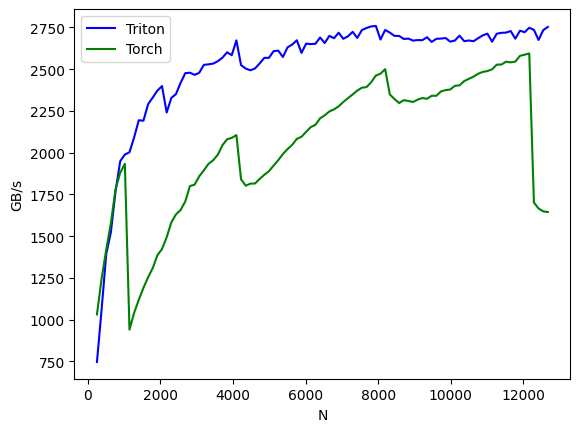

softmax-performance:
          N       Triton        Torch
0     256.0   747.422644  1031.847758
1     384.0  1060.653040  1245.379774
2     512.0  1393.056979  1419.245989
3     640.0  1524.467622  1579.269816
4     768.0  1768.862475  1781.544042
5     896.0  1948.950213  1880.204631
6    1024.0  1988.966142  1933.369713
7    1152.0  2002.839518   940.762018
8    1280.0  2092.294574  1041.748986
9    1408.0  2194.412535  1119.133928
10   1536.0  2191.726775  1191.297787
11   1664.0  2290.507272  1253.634565
12   1792.0  2330.106884  1309.227803
13   1920.0  2371.925007  1386.144464
14   2048.0  2398.696114  1423.695438
15   2176.0  2240.827929  1494.137819
16   2304.0  2328.065694  1582.491404
17   2432.0  2351.222882  1630.998390
18   2560.0  2418.567543  1656.881817
19   2688.0  2476.234896  1708.367841
20   2816.0  2479.048065  1800.323389
21   2944.0  2466.164869  1808.862921
22   3072.0  2478.470616  1858.421916
23   3200.0  2526.020791  1894.413036
24   3328.0  2529.099199  193

In [13]:
import pandas
# We instantiate the kernel without interpreter mode to properly launch it on the GPU.
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):

        row_start_ptr = input_ptr + row_idx * input_row_stride
   
        col_offsets = tl.arange(0, BLOCK_SIZE)

        input_ptrs = row_start_ptr + col_offsets

        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        row_minus_max = row - tl.max(row, axis=0) 

        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0) 
        softmax_output = numerator / denominator
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

# ---- #
# We can create a wrapper function that enqueues the kernel along with its associated (meta-)arguments for any given input tensor.
# ---- #

properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8

    num_stages = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)

    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols) 
    return y

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)